In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("Customer.csv", header=True).createOrReplaceTempView("customers")
spark.read.csv("Jacket.csv", header=True).createOrReplaceTempView("jackets")
spark.read.csv("JacketType.csv", header=True).createOrReplaceTempView("jacket_types")
spark.read.csv("Staff.csv", header=True).createOrReplaceTempView("staffs")
spark.read.csv("HeaderTransaction.csv", header=True).createOrReplaceTempView("header_transaction")
spark.read.csv("DetailTransaction.csv", header=True).createOrReplaceTempView("detail_transaction")

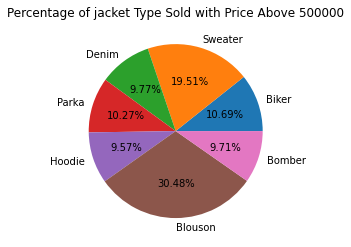

In [ ]:
#a.	Show the percentage of jacket type sold in which the jacket price must be above 500000 using pie plot. 
data = spark.sql("""
  select 
    jt.jackettypename,
    sum(quantity)as sold
  from jacket_types jt
  join jackets j
  on jt.jackettypeid = j.jackettypeid
  join detail_transaction dt
  on j.jacketid = dt.jacketid
  where j.price > 500000
  group by  jt.jackettypename
  
  """).toPandas()

plt.pie(data["sold"], labels=data["jackettypename"], autopct="%.2f%%")
plt.title("Percentage of jacket Type Sold with Price Above 500000")
plt.show()


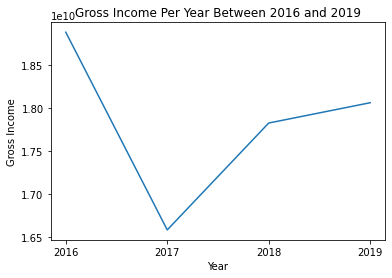

In [ ]:
#b.	Show the number of gross income per year between 2016 until 2019 using line plot.

data = spark.sql("""
  Select 
    year(ht.transactiondate) as year,
    sum(price*quantity) as grossincome
    
  From header_transaction ht 
  JOIN detail_transaction dt
  on ht.transactionid = dt.transactionid
  JOIN jackets j
  ON dt.jacketid = j.jacketid
  WHERE YEAR(ht.TransactionDate) BETWEEN '2016' AND '2019'
  GROUP BY year(ht.TransactionDate)
  ORDER BY year
 """).toPandas()

plt.plot(data["year"], data["grossincome"])
plt.xticks(range(2016,2020))
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.title("Gross Income Per Year Between 2016 and 2019")
plt.show()

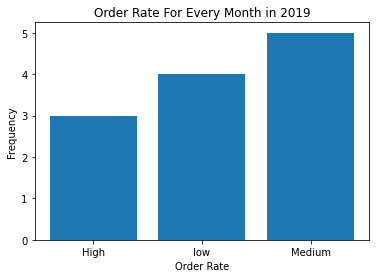

In [ ]:
#c.	Show the frequency of the order rate for every month in 2019 using bar plot. The order rate in a certain month is determined based on the following condition: 
#High	> 4000
#Medium	2501 - 4000
#Low	<= 2500
data = spark.sql("""
  select 
    rate,
    count(*) as count
  from(
    Select 
      month(ht.transactiondate)as month,
      sum(quantity)as total,
      CASE 
        WHEN( sum( quantity)) > 4000 THEN 'High'
        WHEN( sum( quantity)) BETWEEN 2501 and 4000 THEN 'Medium'
        WHEN( sum( quantity)) <= 2500 THEN 'low'
      END as rate
      
    From header_transaction ht 
    JOIN detail_transaction dt
    on ht.transactionid = dt.transactionid
    where year(ht.transactiondate) = '2019'
    group by month(ht.transactiondate)
    order by month
  )
  group by rate

 """).toPandas()

plt.bar(data["rate"], data["count"])
plt.xlabel("Order Rate")
plt.ylabel("Frequency")
plt.title("Order Rate For Every Month in 2019")
plt.show()


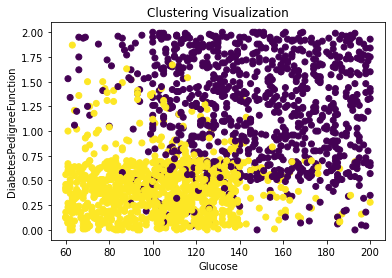

Accuracy: 91.01479915433404%


In [ ]:
testing = spark.read.csv("Test.csv" , header = True, inferSchema = True)
training = spark.read.csv("Train.csv" , header = True, inferSchema = True)

columns = ["Glucose","DiabetesPedigreeFunction","Insulin"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Glucose","DiabetesPedigreeFunction","Insulin","Outcome")
training = training.select(columns)


from pyspark.sql.functions import when 

testing = testing.withColumn(
    "Outcome",
    when (testing["Outcome"] == "No",1).otherwise(0)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler


assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2,seed = 1 )
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()
plt.scatter(
    data["Glucose"],
    data["DiabetesPedigreeFunction"],
    c = data["prediction"]

)
plt.title ("Clustering Visualization")
plt.xlabel("Glucose")
plt.ylabel("DiabetesPedigreeFunction")
plt.show()

c = 0 
for idx, row in data.iterrows():
  if row["Outcome"] == row["prediction"]:
    c += 1

acc  =c/len(data) * 100
print(f'Accuracy: {acc}%')